In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
# доработка для задания 2 - stochastic_sample_size определяет относительный размер случайной подвыборки [0, 1]
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, stochastic_sample_size):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if stochastic_sample_size is not None:
            n = X_train.shape[0]
            indexes = np.random.randint(0, n, int(n * stochastic_sample_size))
            X = X_train[indexes]
            y = y_train[indexes]
        else:
            X = X_train
            y = y_train
            

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X, y)
            
            train_errors.append(mean_squared_error(y, gb_predict(X, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X, bias(y, target))
            
            train_errors.append(mean_squared_error(y, gb_predict(X, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
def evaluate_alg(n_trees, max_depth, eta, stochastic_sample_size = None):

    coefs = [1] * n_trees
    
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, stochastic_sample_size)
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)

    train_error = mean_squared_error(y_train, train_prediction)
    test_error = mean_squared_error(y_test, test_prediction)
    
    print(f'{n_trees} деревьев глубиной {max_depth} с шагом {eta}: train_error: {train_error:.2f}, test_error: {test_error:.2f}')

    return (train_error, test_error, train_errors, test_errors)


In [10]:
evaluate_alg(10, 3, 0.5)

10 деревьев глубиной 3 с шагом 0.5: train_error: 1245.88, test_error: 3789.99


(1245.8787845121099,
 3789.9898473601993,
 [28870.33009708738,
  9344.440865132185,
  4131.840571014778,
  2580.0165775265496,
  2068.778422186302,
  1857.0345681332747,
  1730.146372441136,
  1550.6828345276526,
  1432.9588437798352,
  1356.7780392183092],
 [29548.78947368421,
  10154.98739742778,
  5208.523872118154,
  4206.207382276166,
  3861.9989641288284,
  3678.984049976517,
  3796.2149960027964,
  3711.74709257625,
  3741.086098625562,
  3640.536951508855])

In [11]:
def get_error_plot(title, x_range, x_label, train_err, test_err, train_err_s, test_err_s):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('MSE')
    plt.plot(x_range, train_err, label='train error')
    plt.plot(x_range, test_err, label='test error')
    plt.plot(x_range, train_err_s, label='train error - stochastic')
    plt.plot(x_range, test_err_s, label='test error - stochastic')
    plt.legend(loc='upper right')
    plt.show()

In [12]:
def evaluate_alg_ranges(n_trees_range, max_depth_range, eta, stochastic_sample_size):
    n_trees_errors   = {}
    max_depth_errors = {}

    for n_trees in n_trees_range:
        max_depth_errors[n_trees] = ([], [], [], [])
    for max_depth in max_depth_range:
        n_trees_errors[max_depth] = ([], [], [], [])

    for n_trees in n_trees_range:
        for max_depth in max_depth_range:
            # протестировать нестохастический бустинг
            train_error, test_error, train_errors, test_errors = evaluate_alg(n_trees, max_depth, eta)
            # протестировать стохастический бустинг
            train_error_s, test_error_s, train_errors_s, test_errors_s = evaluate_alg(n_trees, max_depth, eta, stochastic_sample_size)

            max_depth_errors[n_trees][0].append(train_error)
            max_depth_errors[n_trees][1].append(test_error)
            max_depth_errors[n_trees][2].append(train_error_s)
            max_depth_errors[n_trees][3].append(test_error_s)
            n_trees_errors[max_depth][0].append(train_error)
            n_trees_errors[max_depth][1].append(test_error)
            n_trees_errors[max_depth][2].append(train_error_s)
            n_trees_errors[max_depth][3].append(test_error_s)
            if len(train_errors) > 1:
                get_error_plot(f'Errors for {n_trees} trees, max depth {max_depth}', list(range(len(train_errors))), "Iterations", train_errors, test_errors, train_errors_s, test_errors_s)

    for n_trees, data in max_depth_errors.items():
        get_error_plot(f'Errors for {n_trees} trees', max_depth_range, "Max tree depth", *data)
    for max_depth, data in n_trees_errors.items():
        get_error_plot(f'Errors for tree depth {max_depth}', n_trees_range, "Trees", *data)

1 деревьев глубиной 1 с шагом 0.5: train_error: 10318.30, test_error: 11265.36
1 деревьев глубиной 1 с шагом 0.5: train_error: 11094.85, test_error: 11269.35
1 деревьев глубиной 2 с шагом 0.5: train_error: 9707.14, test_error: 10304.12
1 деревьев глубиной 2 с шагом 0.5: train_error: 10459.29, test_error: 11208.68
1 деревьев глубиной 4 с шагом 0.5: train_error: 9071.19, test_error: 10107.60
1 деревьев глубиной 4 с шагом 0.5: train_error: 10625.57, test_error: 11037.53
1 деревьев глубиной 8 с шагом 0.5: train_error: 7783.84, test_error: 10418.95
1 деревьев глубиной 8 с шагом 0.5: train_error: 10082.27, test_error: 11701.64
1 деревьев глубиной 16 с шагом 0.5: train_error: 7217.87, test_error: 10396.56
1 деревьев глубиной 16 с шагом 0.5: train_error: 8829.85, test_error: 9209.40
5 деревьев глубиной 1 с шагом 0.5: train_error: 3032.20, test_error: 3367.11
5 деревьев глубиной 1 с шагом 0.5: train_error: 3195.99, test_error: 3362.97


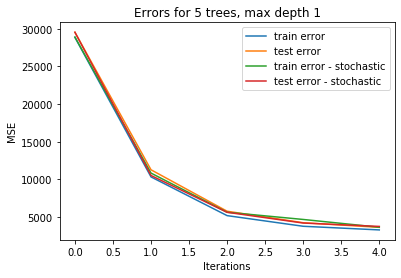

5 деревьев глубиной 2 с шагом 0.5: train_error: 2511.24, test_error: 3546.81
5 деревьев глубиной 2 с шагом 0.5: train_error: 2724.70, test_error: 3548.57


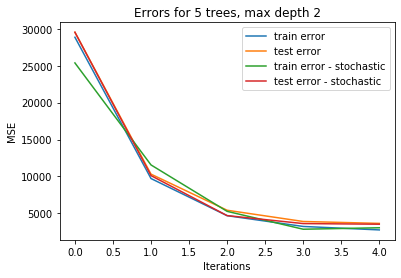

5 деревьев глубиной 4 с шагом 0.5: train_error: 1326.59, test_error: 3820.86
5 деревьев глубиной 4 с шагом 0.5: train_error: 2340.35, test_error: 4719.81


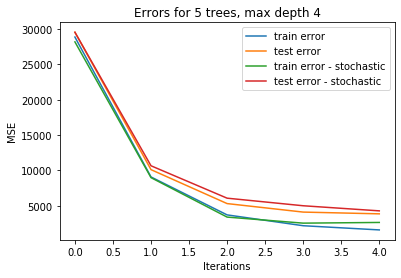

5 деревьев глубиной 8 с шагом 0.5: train_error: 73.19, test_error: 4423.52
5 деревьев глубиной 8 с шагом 0.5: train_error: 2265.42, test_error: 5672.26


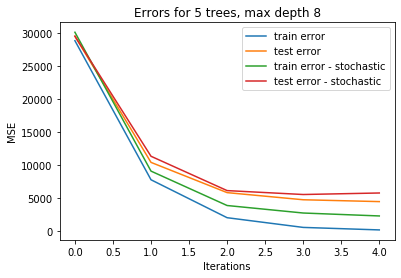

5 деревьев глубиной 16 с шагом 0.5: train_error: 28.22, test_error: 5644.48
5 деревьев глубиной 16 с шагом 0.5: train_error: 1945.40, test_error: 6390.76


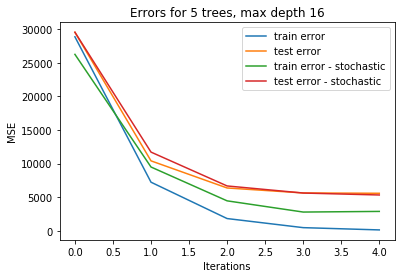

10 деревьев глубиной 1 с шагом 0.5: train_error: 2646.94, test_error: 3414.26
10 деревьев глубиной 1 с шагом 0.5: train_error: 2831.99, test_error: 3713.21


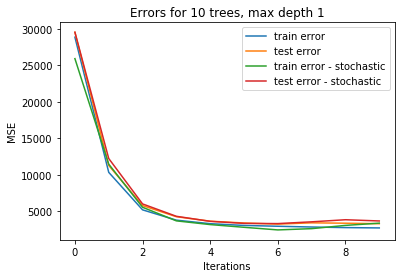

10 деревьев глубиной 2 с шагом 0.5: train_error: 2125.15, test_error: 3471.82
10 деревьев глубиной 2 с шагом 0.5: train_error: 2596.29, test_error: 4396.21


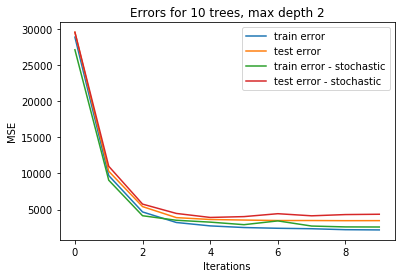

10 деревьев глубиной 4 с шагом 0.5: train_error: 659.34, test_error: 3902.13
10 деревьев глубиной 4 с шагом 0.5: train_error: 1700.56, test_error: 4778.14


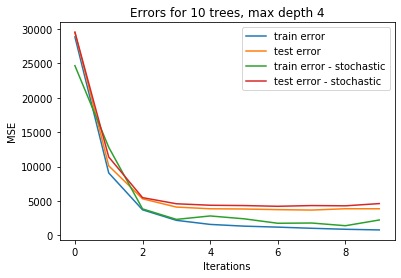

10 деревьев глубиной 8 с шагом 0.5: train_error: 2.49, test_error: 4425.36
10 деревьев глубиной 8 с шагом 0.5: train_error: 961.28, test_error: 5602.56


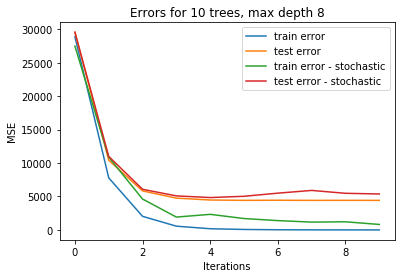

10 деревьев глубиной 16 с шагом 0.5: train_error: 0.03, test_error: 5748.33
10 деревьев глубиной 16 с шагом 0.5: train_error: 648.71, test_error: 6320.76


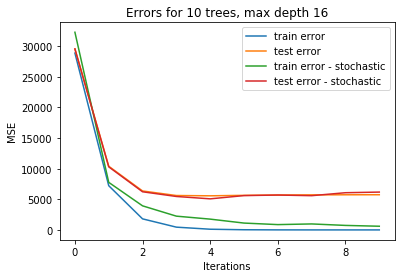

20 деревьев глубиной 1 с шагом 0.5: train_error: 2422.15, test_error: 3316.24
20 деревьев глубиной 1 с шагом 0.5: train_error: 2752.84, test_error: 3989.95


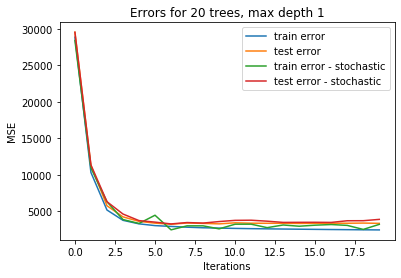

20 деревьев глубиной 2 с шагом 0.5: train_error: 1708.73, test_error: 3725.87
20 деревьев глубиной 2 с шагом 0.5: train_error: 2450.13, test_error: 5650.02


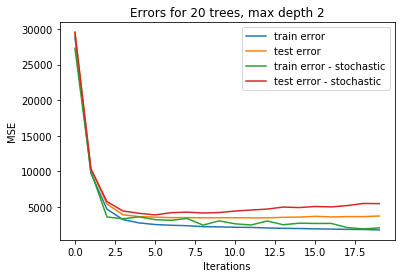

In [ ]:
n_trees_range    = [1, 5, 10, 20]
max_depth_range  = [1, 2, 4, 8, 16]
eta = 0.5
stochastic_sample_size = 0.5

evaluate_alg_ranges(n_trees_range, max_depth_range, eta, stochastic_sample_size)


## Выводы:
* Выполнены задания 1 и 2, задание 3 (опция) не выполнено 
* В зависимости от числа деревьев, наилучший результат на тестовых данных обычно достигался для 5 деревьев
* В зависимости от глубины дерева, наилучший результат на тестовых данных обычно достигался на глубине 1, но это было наихудшим результатом на тренировочных данных. Это странный результат. На тренировочных данных ошибка уменьшалась почти до 0 с увеличением глубины
* Стохастический boosting позволил ускорить тренировку, но обычно терял в точности
* eta 1 давало хороший результат на обычном бустинге, но существенно худший на стохастическом